<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>I – Fusion multimodale texte–image</h2>

<p>
Cette partie vise à évaluer l’apport d’une <b>fusion multimodale</b> combinant les
informations textuelles et visuelles pour la classification des produits. Les
expérimentations précédentes ont permis d’identifier et de valider des modèles
performants pour chaque modalité prise séparément, ainsi que des stratégies de
fusion intra-modales robustes.
</p>

<p>
Du côté du texte, un modèle final basé sur un <b>blending pondéré</b> de
<b>CamemBERT-large</b>, <b>XLM-R</b> et de features <b>TF-IDF</b> atteint un
<b>F1-score pondéré de 0.912</b> sur le jeu de test. Côté image, la fusion des
modèles <b>ConvNeXt</b> et <b>Swin Transformer</b> conduit à un modèle visuel
atteignant un <b>F1-score pondéré de 0.763</b>. Ces deux modèles constituent des
bases solides et complémentaires pour une approche multimodale.
</p>

<p>
Afin de garantir la reproductibilité et d’isoler l’impact des stratégies de
fusion multimodales, les <b>probabilités de sortie</b> de ces deux modèles
intra-modaux ont été <b>pré-calculées et sauvegardées</b>. Le présent notebook se
concentre ainsi exclusivement sur l’étude de deux stratégies de fusion finale :
le <b>blending pondéré</b> et le <b>stacking</b>, appliqués aux sorties probabilistes
des modèles texte et image.
</p>

<p>
Cette démarche permet d’analyser de manière contrôlée l’apport réel de
l’information visuelle par rapport au texte, tout en comparant une approche de
fusion simple et contrainte à une stratégie de fusion apprise plus flexible. Les
résultats obtenus serviront à sélectionner la stratégie multimodale finale
retenue pour la suite du projet.
</p>

</div>

In [1]:
import numpy as np
import pandas as pd

import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, log_loss
from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, '../src')
from data import load_data, CATEGORY_SHORT_NAMES, get_image_path
from utils.calibration import fit_temperature, calibrated_probas, normalize_probas, weights_from_logloss

from visualization import plot_classification_report, plot_f1_comparison_with_delta, display_df_with_images

from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import HTML

In [2]:
_, X_val, X_test, y_train, y_val, y_test = load_data(splitted=True).values()
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train.tolist())
y_val = encoder.transform(y_val.tolist())
y_test = encoder.transform(y_test.tolist())

idx = np.arange(len(y_val))

idx_meta, idx_eval = train_test_split(
    idx,
    test_size=0.30,
    random_state=42,
    stratify=y_val
)

In [3]:
P_val_txt = np.load("../models/fusion/text/proba_text_val.npy")
P_test_txt = np.load("../models/fusion/text/proba_text_test.npy")
P_val_im = np.load("../models/fusion/image/proba_image_val.npy")
P_test_im = np.load("../models/fusion/image/proba_image_test.npy")

In [4]:
# BLENDING MULTIMODAL (TEXTE + IMAGE) AVEC CALCUL DES POIDS

rows = []

# --- Probabilités disponibles ---
probas_mm = {
    "text": normalize_probas(P_val_txt),
    "image": normalize_probas(P_val_im),
}

configs_mm = {
    "texte + image": ["text", "image"],
}

for config_name, models in configs_mm.items():

    log_losses = {
        m: log_loss(y_val, probas_mm[m])
        for m in models
    }

    weights = weights_from_logloss(log_losses)

    P_blend = sum(weights[m] * probas_mm[m] for m in models)
    P_blend = normalize_probas(P_blend)

    y_pred = np.argmax(P_blend, axis=1)

    f1 = f1_score(
        y_val[idx_eval],
        y_pred[idx_eval],
        average="weighted"
    )

    ll = log_loss(
        y_val[idx_eval],
        P_blend[idx_eval]
    )

    rows.append({
        "configuration": f"blending - {config_name}",
        "w_text": weights.get("text", 0.0),
        "w_image": weights.get("image", 0.0),
        "f1_weighted": f1,
        "log_loss": ll,
    })

df_blending_mm = pd.DataFrame(rows).set_index("configuration")



# STACKING MULTIMODAL (TEXTE + IMAGE)

rows = []

for config_name, models in configs_mm.items():

    X_meta = np.concatenate(
        [probas_mm[m] for m in models],
        axis=1
    )

    X_meta_train = X_meta[idx_meta]
    X_meta_eval = X_meta[idx_eval]

    y_train = y_val[idx_meta]
    y_eval = y_val[idx_eval]

    meta_model = LogisticRegression(
        max_iter=3000,
        n_jobs=-1,
    )

    meta_model.fit(X_meta_train, y_train)

    P_eval = meta_model.predict_proba(X_meta_eval)
    P_eval = P_eval / P_eval.sum(axis=1, keepdims=True)

    y_pred = np.argmax(P_eval, axis=1)

    f1 = f1_score(
        y_eval,
        y_pred,
        average="weighted"
    )

    ll = log_loss(
        y_eval,
        P_eval
    )

    rows.append({
        "configuration": f"stacking - {config_name}",
        "f1_weighted": f1,
        "log_loss": ll,
    })

df_stacking_mm = pd.DataFrame(rows).set_index("configuration")


# TABLEAU FINAL

scores_mm = pd.concat(
    [df_blending_mm, df_stacking_mm],
    axis=0
)

scores_mm


,w_text,w_image,f1_weighted,log_loss
configuration,,,,
blending - texte + image,0.726607,0.273393,0.921911,0.359794
stacking - texte + image,NaN,NaN,0.922015,0.296934


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h4>Analyse des résultats de la fusion multimodale</h4>

<p>
Le tableau ci-dessus compare deux stratégies de fusion multimodale appliquées aux
sorties probabilistes des modèles texte et image : un <b>blending pondéré</b> et un
<b>stacking</b> final basé sur un méta-classifieur logistique.
</p>

<p>
La stratégie de <b>blending texte + image</b> atteint un
<b>F1-score pondéré de 0.922</b>, avec un poids majoritaire attribué au texte
(≈&nbsp;0.73), confirmant le rôle prépondérant de l’information textuelle dans la
tâche de classification. La contribution de l’image, bien que plus limitée,
apporte néanmoins un gain mesurable par rapport au modèle texte seul.
</p>

<p>
Le <b>stacking texte + image</b> conduit à un
<b>F1-score pondéré très proche</b> de celui du blending, mais se distingue par une
<b>amélioration marquée de la log loss</b>. Cette baisse significative de la log
loss indique une meilleure calibration des probabilités finales, traduisant une
combinaison plus cohérente et plus prudente des signaux issus des deux modalités.
</p>

<p>
Compte tenu de performances de classification comparables, le
<b>stacking</b> est retenu comme <b>modèle multimodal final</b>. Ce choix est motivé
par la meilleure qualité probabiliste obtenue, critère particulièrement
important dans une logique de fusion multimodale et d’exploitation des scores de
confiance.
</p>

</div>

<div style="background:#f0f8ff; padding:14px; border-radius:6px">
    
<h2>II – Évaluation du modèle et analyse des résultats</h2>


<p>
Cette section est consacrée à l’<b>évaluation du modèle final</b> sur le jeu de test,
strictement indépendant des phases d’entraînement et de sélection. L’objectif est
de mesurer la capacité de généralisation du modèle retenu et d’analyser finement
ses performances, à la fois de manière globale et par catégorie.
</p>

<p>
Les prédictions et probabilités produites par le modèle sont également
<b>enregistrées</b> afin de permettre des analyses complémentaires, notamment
l’étude des confusions, l’interprétabilité de la fusion multimodale et la
réutilisation du pipeline final. Cette approche garantit une évaluation rigoureuse
et reproductible des choix méthodologiques effectués.
</p>

</div>

In [5]:
joblib.dump(meta_model, "../models/fusion/multimodal/meta_model_stacking.joblib")

['../models/fusion/multimodal/meta_model_stacking.joblib']

In [6]:
P_test_txt = normalize_probas(P_test_txt)
P_test_im = normalize_probas(P_test_im)

X_test_meta = np.concatenate(
    [P_test_txt, P_test_im],
    axis=1
)

P_test_final = meta_model.predict_proba(X_test_meta)
P_test_final = P_test_final / P_test_final.sum(axis=1, keepdims=True)

y_test_pred = np.argmax(P_test_final, axis=1)

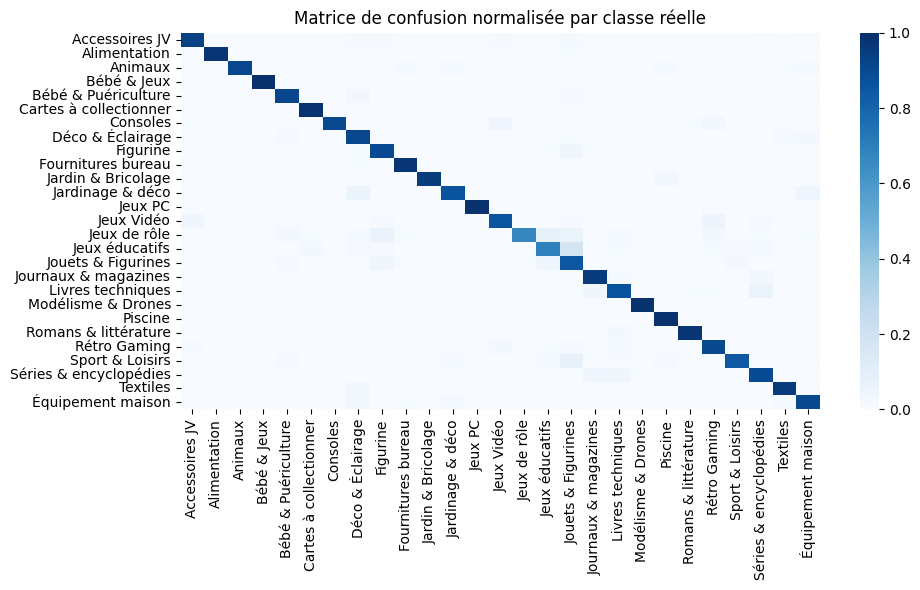


Classes avec les meilleurs scores F1 (top 5)


,precision,recall,f1-score,support
Bébé & Jeux,1.000,1.000,1.000,121.0
Jeux PC,1.000,0.992,0.996,131.0
Modélisme & Drones,0.995,0.992,0.993,757.0
Piscine,0.985,0.993,0.989,1531.0
Cartes à collectionner,0.982,0.988,0.985,593.0



Classes avec les plus faibles scores F1 (bottom 5)


,precision,recall,f1-score,support
Sport & Loisirs,0.895,0.842,0.868,374.0
Livres techniques,0.856,0.867,0.862,467.0
Jouets & Figurines,0.812,0.851,0.831,731.0
Jeux de rôle,0.906,0.670,0.770,115.0
Jeux éducatifs,0.782,0.691,0.734,311.0



Confusions les plus fréquentes (top 5)


,Classe réelle,Classe prédite,% des prédictions de la classe réelle
0,Jeux éducatifs,Jouets & Figurines,18.3
1,Jeux de rôle,Jeux éducatifs,7.8
2,Sport & Loisirs,Jouets & Figurines,7.5
3,Jeux de rôle,Figurine,7.0
4,Jeux de rôle,Jouets & Figurines,6.1


In [7]:
# plot_f1_comparison_with_delta(y_test, y_pred, y_pred_cam, new_name="fusion", ref_name="camembert", encoder=encoder)
plot_classification_report(y_test, y_test_pred, encoder=encoder, k_best_f1=5)

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h4>Analyse des performances par classe et des confusions</h4>

<p>
L’analyse détaillée des performances par classe met en évidence une forte
hétérogénéité des scores, reflétant la nature intrinsèque des catégories et la
clarté variable de leurs frontières sémantiques et visuelles.
</p>

<p>
Les classes présentant les <b>meilleurs scores de F1</b> correspondent à des
catégories bien définies, tant du point de vue textuel que visuel. Des classes
comme <b>Bébé &amp; Jeux</b>, <b>Jeux PC</b>, <b>Modélisme &amp; Drones</b>,
<b>Piscine</b> ou <b>Cartes à collectionner</b> atteignent des scores proches de la
perfection. Ces performances s’expliquent par des descriptions produits très
spécifiques, un vocabulaire distinctif et, dans certains cas, des indices
visuels particulièrement discriminants (emballages, formes ou usages clairement
identifiables).
</p>

<p>
À l’inverse, les <b>classes présentant les scores de F1 les plus faibles</b> sont
celles dont les frontières sont plus floues ou qui recouvrent des usages et des
objets hétérogènes. Les catégories <b>Jeux éducatifs</b>, <b>Jeux de rôle</b>,
<b>Jouets &amp; Figurines</b>, <b>Livres techniques</b> et
<b>Sport &amp; Loisirs</b> regroupent des produits aux descriptions souvent
ambiguës, partageant un vocabulaire commun et des thématiques proches, ce qui
limite la séparabilité des classes.
</p>

<p>
L’étude des confusions les plus fréquentes confirme cette interprétation. La
confusion dominante entre <b>Jeux éducatifs</b> et
<b>Jouets &amp; Figurines</b> (18,3&nbsp;% des erreurs de la classe) traduit une
forte proximité sémantique et fonctionnelle entre ces catégories. De même, les
<b>Jeux de rôle</b> sont majoritairement confondus avec
<b>Jeux éducatifs</b> ou <b>Figurine</b>, ce qui reflète des descriptions produits
souvent hybrides, à la frontière entre jeu, apprentissage et collection.
</p>

<p>
Les confusions observées pour la catégorie <b>Sport &amp; Loisirs</b> avec
<b>Jouets &amp; Figurines</b> illustrent quant à elles une limite classique des
approches basées sur le contenu : certaines descriptions mettent davantage en
avant l’aspect ludique ou visuel du produit que son usage sportif réel, induisant
des erreurs cohérentes d’un point de vue métier.
</p>

<p>
Dans l’ensemble, ces résultats montrent que les erreurs du modèle final sont
principalement concentrées sur des <b>zones grises du problème de
classification</b>, où même une annotation humaine peut s’avérer ambiguë. Les
bonnes performances observées sur les classes bien définies et la nature
sémantiquement cohérente des confusions confirment la robustesse du modèle
multimodal retenu.
</p>

<p>
Ces observations suggèrent que des améliorations futures pourraient être obtenues
via un enrichissement contextuel des données (descriptions plus longues,
métadonnées supplémentaires) ou par une exploitation plus fine de l’information
visuelle pour les catégories aux frontières les plus floues.
</p>

</div>


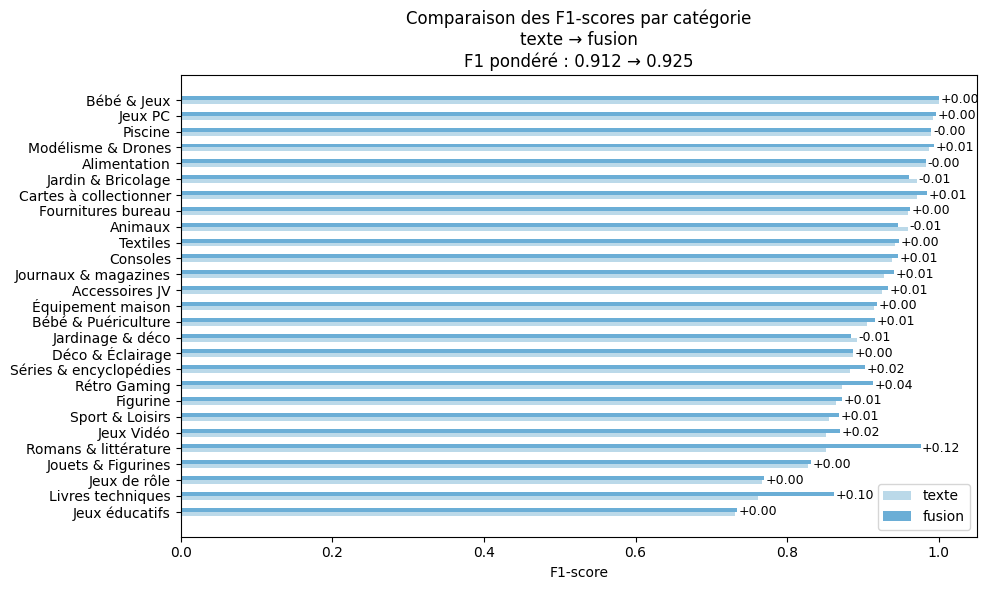

In [69]:
y_pred_txt = np.argmax(P_test_txt, axis=1)
y_pred_final = np.argmax(P_test_final, axis=1)
plot_f1_comparison_with_delta(y_test, y_pred_final, y_pred_txt, new_name="fusion", ref_name="texte", encoder=encoder)

<div style="background:#f7fbff; padding:14px; border-radius:6px">

<p>
L’analyse des <b>F1-scores par catégorie</b> met en évidence un comportement global
très stable du modèle multimodal par rapport au modèle texte seul. Pour la grande
majorité des classes, les performances restent similaires ou progressent
légèrement, ce qui indique que l’introduction de l’information visuelle ne
déstabilise pas les décisions déjà bien maîtrisées par le texte.
</p>

<p>
Les gains observés sont principalement <b>ciblés et non uniformes</b>. La fusion
multimodale apporte peu de bénéfice sur les catégories déjà très bien séparées
(textes fortement discriminants ou signatures visuelles peu spécifiques), mais
améliore sensiblement les performances sur certaines classes présentant des
<b>ambiguïtés sémantiques</b> dans les descriptions textuelles.
</p>

<p>
Deux catégories se distinguent nettement : <b>Livres techniques</b> et
<b>Romans &amp; littérature</b>, qui enregistrent des hausses de F1-score
particulièrement importantes. Ces gains suggèrent que la fusion multimodale agit
principalement comme un <b>mécanisme de désambiguïsation</b> entre des catégories
textuellement proches.
</p>

<p>
Afin de vérifier cette hypothèse, l’analyse suivante se concentre sur l’évolution
des <b>confusions croisées</b> entre ces deux catégories, en comparant le modèle
texte seul et le modèle multimodal final, pour évaluer dans quelle mesure l’apport
de l’image permet de réduire ces erreurs spécifiques.
</p>

</div>


In [88]:
def confusion_rate(y_true, y_pred, true_idx, pred_idx):
    """
    Pourcentage des échantillons de la classe true_idx
    prédits comme pred_idx.
    """
    mask_true = (y_true == true_idx)
    if mask_true.sum() == 0:
        return 0.0

    confused = (y_pred == pred_idx) & mask_true
    return confused.sum() / mask_true.sum() * 100

categories = [CATEGORY_SHORT_NAMES[c] for c in encoder.inverse_transform(range(27))]

idx_lt = categories.index('Livres techniques')
idx_rl = categories.index('Romans & littérature')

rate_txt_rl_to_lt = confusion_rate(y_test, y_pred_txt, idx_rl, idx_lt)
rate_txt_lt_to_rl = confusion_rate(y_test, y_pred_txt, true_idx=idx_lt, pred_idx=idx_rl)
rate_final_rl_to_lt = confusion_rate(y_test, y_pred_final, true_idx=idx_rl, pred_idx=idx_lt)
rate_final_lt_to_rl = confusion_rate(y_test, y_pred_final, true_idx=idx_lt, pred_idx=idx_rl)

df_confusion = pd.DataFrame({
    "Confusion": ["Romans & littérature → Livres techniques", "Livres techniques → Romans & littérature"],
    "Texte seul (%)": [rate_txt_rl_to_lt, rate_txt_lt_to_rl],
    "Modèle final (%)": [rate_final_rl_to_lt, rate_final_lt_to_rl],
})

df_confusion.round(2)

,Confusion,Texte seul (%),Modèle final (%)
0,Romans & littérature → Livres techniques,11.11,2.66
1,Livres techniques → Romans & littérature,9.85,1.07


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h4>Analyse des confusions entre <i>Livres techniques</i> et <i>Romans &amp; littérature</i></h4>

<p>
L’analyse des confusions croisées entre les catégories <b>Livres techniques</b> et
<b>Romans &amp; littérature</b> met en évidence un <b>impact très significatif de la
fusion multimodale</b>. Avec le modèle texte seul, ces deux catégories présentent
des taux de confusion élevés et relativement symétriques, traduisant une forte
proximité sémantique dans les descriptions produits.
</p>

<p>
Pour le modèle texte, plus de <b>11&nbsp;%</b> des produits appartenant à la
catégorie <b>Romans &amp; littérature</b> sont prédits comme
<b>Livres techniques</b>, tandis que près de <b>10&nbsp;%</b> des
<b>Livres techniques</b> sont confondus avec des
<b>Romans &amp; littérature</b>. Ces erreurs reflètent des descriptions parfois
génériques ou hybrides, insuffisantes pour distinguer clairement la nature des
ouvrages.
</p>

<p>
Avec le <b>modèle multimodal final</b>, ces confusions sont fortement réduites.
Le taux d’erreur <b>Romans &amp; littérature → Livres techniques</b> chute à
<b>2,7&nbsp;%</b>, tandis que la confusion inverse descend à
<b>1,1&nbsp;%</b>. Cette diminution très nette confirme que l’ajout de
l’information visuelle permet de <b>désambiguïser efficacement</b> des catégories
textuellement proches mais visuellement distinctes.
</p>

<p>
Ces résultats fournissent une explication directe aux gains importants de
F1-score observés précédemment pour ces deux catégories, et illustrent le rôle
du multimodal comme un <b>mécanisme correctif ciblé</b>, plutôt qu’un simple
lissage global des prédictions.
</p>

</div>

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>III – Importance relative des modalités texte et image</h2>

<p>
Afin de mieux comprendre <b>comment</b> le modèle multimodal exploite la
complémentarité entre les différentes sources d’information, il est désormais
pertinent d’analyser l’<b>importance relative des modalités texte et image</b>
dans la décision finale.
</p>

<p>
Cette analyse s’appuie sur les coefficients du méta-classifieur de stacking, qui
fournissent une mesure interprétable de la sensibilité du modèle aux
probabilités issues de chaque modalité. Elle permet d’évaluer, à la fois de
manière globale et catégorie par catégorie, le poids relatif accordé au texte et
à l’image dans le processus de décision.
</p>

<p>
En particulier, l’étude de cette importance par catégorie permet de vérifier si
le <b>poids accordé à l’image est effectivement plus élevé</b> pour les
catégories <b>Livres techniques</b> et <b>Romans &amp; littérature</b>, en
cohérence avec la <b>forte réduction des confusions</b> observée précédemment
entre ces deux classes. Cette mise en relation entre performances et
interprétabilité vise à mieux caractériser le rôle joué par chaque modalité dans
les gains apportés par la fusion multimodale.
</p>

</div>


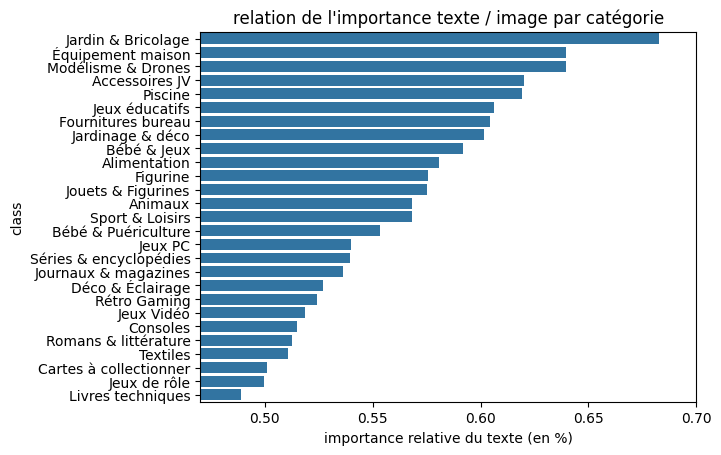

In [49]:
coef = meta_model.coef_  # shape (n_classes, 2 * n_classes)

n_classes = coef.shape[1] // 2

coef_text = coef[:, :n_classes]
coef_image = coef[:, n_classes:]

rows = []

for i, cat in enumerate(categories):
    text_importance = np.mean(np.abs(coef_text[i]))
    image_importance = np.mean(np.abs(coef_image[i]))
    text_importance_rate = text_importance / (text_importance + image_importance)
    
    rows.append({
        "class": cat,
        "text_importance_rate": text_importance_rate,
        "text_importance": text_importance,
        "image_importance": image_importance,
    })
    

df_importance = pd.DataFrame(rows).sort_values("text_importance_rate", ascending=False)


importance_text = np.mean(np.abs(coef_text))
importance_image = np.mean(np.abs(coef_image))

beautiful_print(
    f"importance globale du <b>texte</b> sur l'importance de l'image pour le modèle : <b>{importance_text*100 / (importance_text+importance_image):.2f}% </b>"
)

sns.barplot(data=df_importance, y='class', x='text_importance_rate', orient='h')
plt.xlabel('importance relative du texte (en %)')
plt.title("relation de l'importance texte / image par catégorie")
plt.xlim(0.47,0.7)
plt.show()

<div style="background:#f7fbff; padding:14px; border-radius:6px">

<h4>Analyse synthétique de l’importance relative du texte et de l’image</h4>

<p>
L’analyse des coefficients du méta-classifieur de stacking permet d’évaluer
l’<b>importance relative des modalités texte et image</b> dans la décision finale
du modèle multimodal. À l’échelle globale, le texte représente environ
<b>56,5&nbsp;% de l’importance totale</b>, contre <b>43,5&nbsp;% pour l’image</b>,
confirmant le rôle dominant du texte tout en soulignant une contribution visuelle
non négligeable.
</p>

<p>
Cette importance varie toutefois fortement selon les catégories. De nombreuses
classes restent <b>majoritairement texte-dépendantes</b> (par exemple
<b>Jardin &amp; Bricolage</b>, <b>Équipement maison</b> ou <b>Piscine</b>), tandis
que d’autres présentent une contribution plus équilibrée entre les deux
modalités, traduisant une complémentarité effective.
</p>

<p>
Un point particulièrement intéressant concerne les catégories
<b>Livres techniques</b> et <b>Romans &amp; littérature</b>, qui figuraient parmi
les plus fortement confondues avec le modèle texte seul. Pour ces deux classes,
l’importance de l’image est <b>comparable, voire supérieure</b> à celle du texte,
ce qui est cohérent avec la <b>forte réduction des confusions croisées</b>
observée précédemment. L’information visuelle (couvertures, mise en page,
illustrations) joue ici un rôle déterminant pour désambiguïser des descriptions
textuelles proches.
</p>

<p>
Dans l’ensemble, cette analyse confirme que la fusion multimodale ne modifie pas
uniformément les décisions, mais agit comme un <b>mécanisme correctif ciblé</b>,
particulièrement efficace pour les catégories où le texte seul atteint ses
limites.
</p>

<h4>Exemple de prédiction</h4>

<p>
Afin d’illustrer concrètement ces résultats, nous allons voir quelques <b>exemples de prédictions</b>. Ils permettent d’observer, à l’échelle
d’instances individuelles, <b>l’impact respectif du texte et de l’image</b> dans
la décision finale du modèle multimodal, et de mieux comprendre comment la fusion
arbitre entre les deux modalités.
</p>

</div>


,Unnamed: 0,designation,description,productid,imageid,image
52915,52915,Kit piscine acier blanc Gré Haïti ovale 634 x 399 x 132 m + Bâche à bulles + Kit d'entretien + Douche,Piscine hors-sol acier blanc Haïti ovale de la marque Gré.Cette gamme de piscines ovales en acier vous offrira un grand espace de nage et s'intégrera harmonieusement dans votre jardin avec son coloris blanc. La piscine en acier ovale Haïti c'est :? Une structure en acier galvanisé d'une épaisseur de 45/100 de couleur blanc. Renforcée par des poteaux de 12 cm de large ainsi que par plusieurs jambes de force (le nombre de jambes de force varie selon la taille de la piscine).? Un liner de couleur bleu en pvc d'une épaisseur de 40/100. Il se fixe à la structure avec un system Overlap.Elle dispose d'un équipement complet : ? Filtration à sable de 5 à 10 m³/h (selon la taille de piscine)? ¿Échelle de sécurité avec marche amovible? Skimmer? Tapis de solPlusieurs modèles sont disponibles : KITPROV6188 : Piscine acier blanc Gré Haïti ovale 634 x 399 m? Dimensions extérieures (L x l x H) : 634 x 399 x 132 m? Dimensions intérieures (L x l x H) : 610 x 375 m? Espace nécessaire : 650 x 495 m? Volume d'eau : 233 m³KITPROV738 : Piscine acier blanc Gré Haïti ovale 744 x 399 m? Dimensions extérieures (L x l x H) : 744 x 399 x 132 m? Dimensions intérieures (L x l x H) : 730 x 375 m? Espace nécessaire : 770 x 495 m? Volume d'eau : 282 m³KITPROV818 : Piscine acier blanc Gré Haïti ovale 815 x 490 m? Dimensions extérieures (L x l x H) : 815 x 490 x 132 m? Dimensions intérieures (L x l x H) : 800 x 470 m? Espace nécessaire : 850 x 590 m? Volume d'eau : 374 m³KITPROV918 : Piscine acier blanc Gré Haïti ovale 920 x 505 m? Dimensions extérieures (L x l x H) : 920 x 505 x 132 m? Dimensions intérieures (L x l) : 915 x 470 m? Espace nécessaire : 955 x 590 m? Volume d'eau : 436 m³KITPROV1028 : Piscine acier blanc Gré Haïti ovale 1020 x 575 m? Dimensions extérieures (L x l x H) : 1020 x 575 x 132 m? Dimensions intérieures (L x l) : 1000 x 550 m? Espace nécessaire : 1040 x 670 m? Volume d'eau : 561 m³La gamme de piscine hors-sol en acier Haïti bénéficie d'une grantie fabricant de 4 ans sur la structure et de 2 ans sur la filtration à sable le liner ainsi que les accessoires.,3782771543,1244326113,

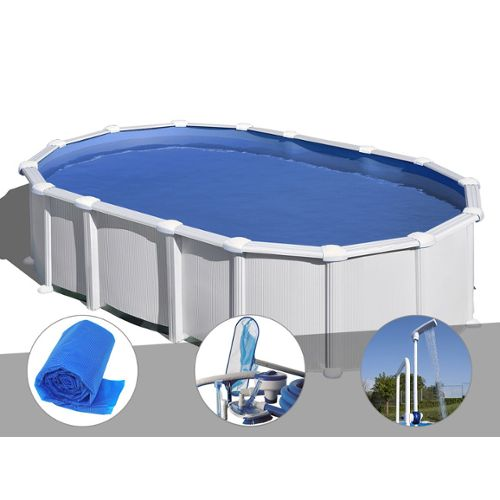

,P_text,P_image,P_final
category,,,
Piscine,0.989,0.898,0.994
Jardin & Bricolage,0.000,0.004,0.002
Jardinage & déco,0.001,0.003,0.001
Sport & Loisirs,0.001,0.003,0.000
Fournitures bureau,0.000,0.005,0.000


,Unnamed: 0,designation,description,productid,imageid,image
66558,66558,Set De Pétanque 6 Boules + Malette Poker En Bois,"Ce Set de 6 boules de Pétanque est fourni dans une malette en bois. Cette malette en bois est idéale pour le rangement ainsi que le transport de votre set de 6 boules de pétanque. Pourvue d'un intérieur en mousse avec compartiments alvéolés cette malette en bois protégera vos boules de pétanque de l'usure. Ce setcontient: 6 boules de pétanque acier chromé 720 gr. Diamètre: 74mm 1 cochonet en bois 1 mallete en bois 1 mètre ruban L'avis de Pokeo ""La pétanque est un jeu d'adresse en plein air largement pratiqué dès l'arrivée des beaux jours. Le but du jeu est enfantin! Sur un terrain de préférence plat tracez un cercle au sol à partir duquel vous lancerez vos boules. Afin de gagner le point vous devez lancer vos boules afin de les placer le plus près possible du cochonnet. En tête à tête ou en équipe de deux (doublettes) ou trois (triplettes) partagez un moment agréable et chaleureux en famille ou entre amis avec ce set de jeu de pétanque.""",798819712,1039577224,

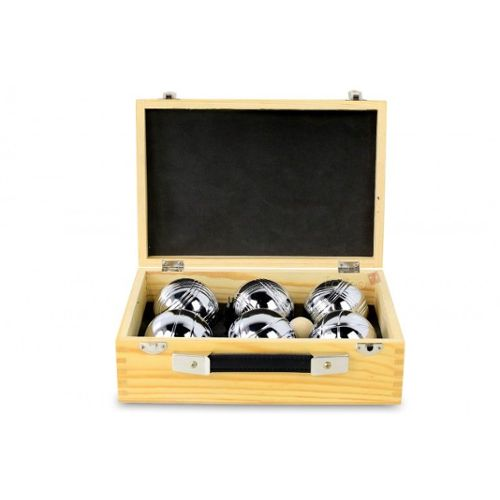

,P_text,P_image,P_final
category,,,
Jeux éducatifs,0.539,0.245,0.633
Sport & Loisirs,0.351,0.019,0.118
Jouets & Figurines,0.031,0.227,0.117
Jeux de rôle,0.010,0.012,0.016
Équipement maison,0.006,0.222,0.010


,Unnamed: 0,designation,description,productid,imageid,image
57173,57173,Xbox 360 Elite (120 Go) Limited Edition Resident Evil 5,NaN,81671673,850117989,

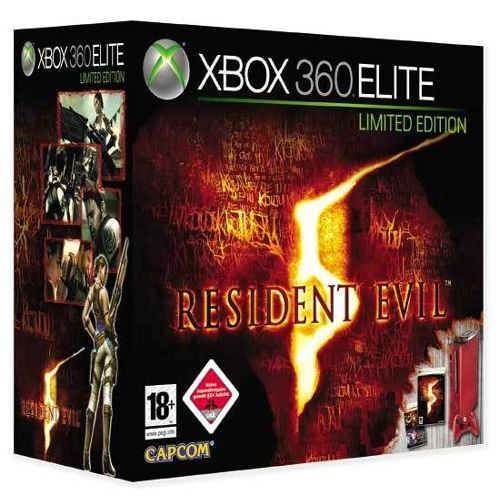

,P_text,P_image,P_final
category,,,
Rétro Gaming,0.099,0.823,0.462
Consoles,0.551,0.024,0.188
Jeux Vidéo,0.273,0.064,0.139
Figurine,0.004,0.003,0.018
Accessoires JV,0.008,0.015,0.017


,Unnamed: 0,designation,description,productid,imageid,image
7693,7693,La Tragédie Du Liberty Ship,NaN,111804359,868445981,

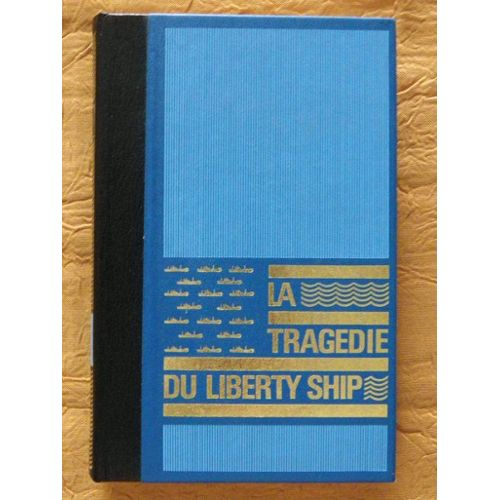

,P_text,P_image,P_final
category,,,
Livres techniques,0.152,0.193,0.267
Séries & encyclopédies,0.103,0.376,0.193
Romans & littérature,0.432,0.002,0.107
Rétro Gaming,0.167,0.006,0.047
Jeux éducatifs,0.041,0.008,0.041


In [97]:
idx = [0,1,13, np.where(y_test == idx_lt)[0][0]]


for j, i in enumerate(idx):

    beautiful_print(f"<h3>Exemple {j+1}</h3>")
    display_df_with_images(X_test.iloc[i:i+1])
    
    df_local = pd.DataFrame({
        "P_text": P_test_txt[i],
        "P_image": P_test_im[i],
        "P_final": P_test_final[i],
        "category": categories,
    })

    true_cat = categories[y_test[i]]
    pred_cat = categories[np.argmax(P_test_final[i])]

    beautiful_print(f"""
        <b>Vraie catégorie :</b> {true_cat}<br>
        <b>Catégorie prédite :</b> {pred_cat}
    """, style="secondary")

    display(df_local.sort_values("P_final", ascending=False).set_index('category').round(3).iloc[:5])

<div style="background:#f7fbff; padding:14px; border-radius:6px">

<h4>Analyse qualitative des prédictions multimodales</h4>

<p>
Afin de compléter l’analyse quantitative, quelques exemples représentatifs sont
présentés ci-dessous afin d’illustrer le comportement du modèle multimodal
final, à la fois dans des cas de prédiction correcte et dans des situations
d’erreur. Ces exemples permettent de mieux comprendre la manière dont les
informations textuelles et visuelles sont combinées par le stacking.
</p>

<p>
<b>Exemple 1 – Prédiction correcte.</b><br>
Dans ce premier cas, le produit correspond clairement à la catégorie
<b>Piscine</b>. Le texte est extrêmement descriptif et contient de nombreux
indices explicites (dimensions, volume d’eau, structure, accessoires), ce qui
conduit le modèle texte à une probabilité très élevée. L’image confirme
visuellement cette interprétation. La fusion multimodale renforce encore cette
confiance, aboutissant à une prédiction finale quasi certaine. Cet exemple
illustre un cas idéal où les deux modalités sont cohérentes et se renforcent
mutuellement.
</p>

<p>
<b>Exemple 2 – Erreur liée à une ambiguïté sémantique.</b><br>
Le produit est un <b>set de pétanque</b>, relevant de la catégorie
<b>Sport &amp; Loisirs</b>. Le texte contient cependant des éléments pouvant être
associés à un usage ludique ou familial, ce qui conduit le modèle texte à
favoriser la catégorie <b>Jeux éducatifs</b>. L’image, bien qu’illustrant des
boules de pétanque, n’apporte pas un signal suffisamment discriminant pour
corriger cette confusion. Le modèle final amplifie alors la prédiction issue du
texte. Cette erreur est cohérente avec les confusions observées globalement entre
les catégories <b>Sport &amp; Loisirs</b>, <b>Jeux éducatifs</b> et
<b>Jouets &amp; Figurines</b>, et reflète une zone grise du problème de
classification.
</p>

<p>
<b>Exemple 3 – Erreur liée à un signal visuel dominant.</b><br>
Dans ce troisième exemple, le produit est une <b>console Xbox 360</b>, appartenant
à la catégorie <b>Consoles</b>. L’absence de description textuelle limite fortement
l’apport du texte, tandis que l’image évoque un produit associé à l’univers du
jeu vidéo. Le modèle image attribue alors une forte probabilité à la catégorie
<b>Rétro Gaming</b>, qui domine la fusion finale. Le stacking privilégie ici le
signal visuel, conduisant à une confusion entre des catégories proches d’un point
de vue visuel et fonctionnel. Cette erreur illustre une limite naturelle du
modèle lorsque l’une des modalités est partiellement absente ou peu informative.
</p>

<p>
<b>Exemple 4 – Désambiguïsation réussie grâce à l’image.</b><br>
Dans cet exemple, le produit <i>La Tragédie du Liberty Ship</i> appartient à la
catégorie <b>Livres techniques</b>. En l’absence de description textuelle, le
modèle texte seul attribue une probabilité élevée à la catégorie
<b>Romans &amp; littérature</b>, illustrant la confusion fréquemment observée
entre ces deux classes. À l’inverse, le modèle image attribue une probabilité
quasi nulle à la catégorie <b>Romans &amp; littérature</b> et favorise davantage
<b>Livres techniques</b>, probablement en s’appuyant sur des indices visuels
propres aux ouvrages techniques ou documentaires. La fusion multimodale permet
ainsi de corriger la prédiction finale en rééquilibrant les signaux textuel et
visuel, confirmant le rôle désambiguïsant de l’image mis en évidence dans les
analyses précédentes.
</p>



<p>
Dans l’ensemble, ces exemples montrent que les erreurs du modèle multimodal sont
majoritairement <b>interprétables et cohérentes</b> d’un point de vue sémantique.
Elles résultent soit d’ambiguïtés intrinsèques entre catégories proches, soit
d’un déséquilibre d’information entre texte et image. À l’inverse, lorsque les
deux modalités sont riches et cohérentes, la fusion permet d’atteindre des
prédictions très fiables.
</p>

</div>

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>IV - Conclusion – Fusion multimodale finale</h2>

<p>
Ce notebook a permis de concevoir, évaluer et analyser un <b>modèle multimodal
final</b> combinant des informations textuelles et visuelles pour la
classification de produits. La stratégie retenue repose sur une fusion en deux
niveaux : un <b>blending intra-modal</b> pour le texte et l’image, suivi d’un
<b>stacking final</b> permettant d’arbitrer entre les deux modalités de manière
interprétable et robuste.
</p>

<p>
Les résultats obtenus montrent que la fusion multimodale permet une
<b>amélioration cohérente et ciblée des performances</b> par rapport au modèle
texte seul, sans dégrader les catégories déjà bien maîtrisées. Les gains les plus
significatifs sont observés sur des classes présentant des ambiguïtés
sémantiques, telles que <b>Livres techniques</b> et
<b>Romans &amp; littérature</b>, pour lesquelles l’apport de l’image permet de
réduire fortement les confusions croisées.
</p>

<p>
L’analyse des confusions et des exemples qualitatifs met en évidence que les
erreurs restantes sont majoritairement <b>interprétables et cohérentes d’un point
de vue métier</b>. Elles résultent soit de zones grises intrinsèques entre
catégories proches, soit de situations où l’une des modalités est absente ou peu
informative. À l’inverse, lorsque texte et image sont complémentaires, la fusion
permet des décisions nettement plus fiables.
</p>

<p>
L’étude de l’<b>importance relative des modalités</b> confirme que le texte
demeure la source principale de décision à l’échelle globale, tout en montrant
que l’image joue un rôle correctif déterminant pour certaines catégories
spécifiques. Cette complémentarité est exploitée de manière différenciée par le
modèle, en accord avec la nature des produits et les observations empiriques
issues de l’analyse par catégorie.
</p>

<p>
Dans l’ensemble, le modèle final retenu constitue un <b>compromis pertinent entre
performance, robustesse et interprétabilité</b>. La stratégie de fusion choisie
reste simple, reproductible et extensible, tout en apportant des gains mesurables
et explicables. Elle fournit ainsi une base solide pour de futures améliorations,
notamment l’intégration de signaux contextuels supplémentaires ou l’enrichissement
des données visuelles et textuelles.
</p>

</div>


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>V - Perspectives d’amélioration</h2>

<p>
Malgré les gains apportés par la fusion multimodale, certaines catégories restent
plus difficiles à distinguer, en particulier <b>Jeux éducatifs</b>,
<b>Jeux de rôle</b> et <b>Jouets &amp; Figurines</b>. Ces classes présentent des
frontières sémantiques et visuelles naturellement floues, ce qui limite la
capacité du modèle à les séparer de manière fiable à partir des seules
informations textuelles et visuelles actuellement exploitées.
</p>

<p>
Un premier axe d’amélioration consisterait à <b>enrichir les signaux
textuels</b>, en intégrant des informations plus structurées lorsque
disponibles, telles que l’âge recommandé, le nombre de joueurs, la durée de jeu
ou le type d’apprentissage visé. Ces attributs sont souvent déterminants pour
différencier un jeu éducatif d’un jouet ou d’un jeu de rôle, mais restent peu
présents dans les descriptions textuelles libres.
</p>

<p>
Du point de vue visuel, une piste prometteuse serait de <b>focaliser davantage le
modèle image sur les éléments discriminants</b>, par exemple en exploitant des
mécanismes d’attention spatiale ou des recadrages automatiques des zones
informatives (illustrations pédagogiques, figurines, plateaux de jeu). Cela
pourrait permettre de réduire l’influence d’éléments visuels génériques communs
à plusieurs catégories.
</p>

<p>
Une autre perspective consisterait à adopter une <b>classification hiérarchique</b>,
en distinguant dans un premier temps les grandes familles de produits (jeux,
livres, équipements), puis en affinant la prédiction au sein de la famille
<b>Jeux</b>. Cette approche permettrait de réduire les confusions locales entre
classes très proches en introduisant une structure explicite dans le processus
de décision.
</p>

<p>
Enfin, l’intégration de <b>signaux contextuels supplémentaires</b>, tels que la
gamme de prix, la marque ou les avis utilisateurs, pourrait apporter des indices
complémentaires utiles pour désambiguïser ces catégories. Ces informations,
facilement accessibles dans un cadre industriel, constituent des leviers
naturels pour améliorer la robustesse du modèle final.
</p>

<p>
Ces pistes soulignent que les limites observées ne relèvent pas uniquement du
choix du modèle, mais sont en grande partie liées à la <b>nature intrinsèquement
ambiguë de certaines catégories</b>. Elles ouvrent néanmoins des perspectives
concrètes pour renforcer la performance du système dans un cadre applicatif
réel.
</p>

</div>
